In [2]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import pandas_datareader as web
import datetime as dt


In [3]:
from sklearn.preprocessing import MinMaxScaler

In [9]:

from tensorflow.keras.models import Sequential

2023-03-28 19:38:21.692449: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [10]:

from tensorflow.keras.layers import Dense, Dropout, LSTM

In [25]:
#Load the data 

company ='OLPX'

start = dt.datetime(2012,1,1)
end = dt.datetime(2023, 3, 28)

data = web.DataReader(company, 'stooq', start, end)


In [26]:
#prepare Data
#scaling all prices between the value of 0 and 1 (COMPRESSION)
scaler = MinMaxScaler(feature_range = (0,1))

#only looking at the closing because we dont need to precit the open only the closing price
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1, 1))
#how many days in the past to predict the next day

prediction_days = 60

x_train = []
y_train = []

for x in range(prediction_days, len(scaled_data)):
    x_train.append(scaled_data[x-prediction_days:x, 0])
    y_train.append(scaled_data[x, 0])
    
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [27]:
#Building the model
model = Sequential()

model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))# predcition of the next closing price

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, epochs=25, batch_size=32)


Epoch 1/25
10/10 [==============================] - 5s 56ms/step - loss: 0.1220
Epoch 2/25
10/10 [==============================] - 1s 52ms/step - loss: 0.0307
Epoch 3/25
10/10 [==============================] - 1s 53ms/step - loss: 0.0200
Epoch 4/25
10/10 [==============================] - 1s 54ms/step - loss: 0.0158
Epoch 5/25
10/10 [==============================] - 0s 49ms/step - loss: 0.0084
Epoch 6/25
10/10 [==============================] - 0s 45ms/step - loss: 0.0103
Epoch 7/25
10/10 [==============================] - 0s 45ms/step - loss: 0.0081
Epoch 8/25
10/10 [==============================] - 0s 44ms/step - loss: 0.0080
Epoch 9/25
10/10 [==============================] - 0s 45ms/step - loss: 0.0097
Epoch 10/25
10/10 [==============================] - 0s 45ms/step - loss: 0.0083
Epoch 11/25
10/10 [==============================] - 0s 46ms/step - loss: 0.0076
Epoch 12/25
10/10 [==============================] - 0s 45ms/step - loss: 0.0088
Epoch 13/25
10/10 [==================

In [28]:
#test the model accuracy on existing data
#Load Test Data

test_start = dt.datetime(2020,1,1)
test_end = dt.datetime.now()

test_data = web.DataReader(company, 'stooq', test_start, test_end)
actual_prices = test_data['Close'].values

total_dataset = pd.concat((data['Close'], test_data['Close']), axis=0)

model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
model_inputs = model_inputs.reshape(-1, 1)

model_inputs = scaler.transform(model_inputs)



12/12 [==============================] - 1s 13ms/step


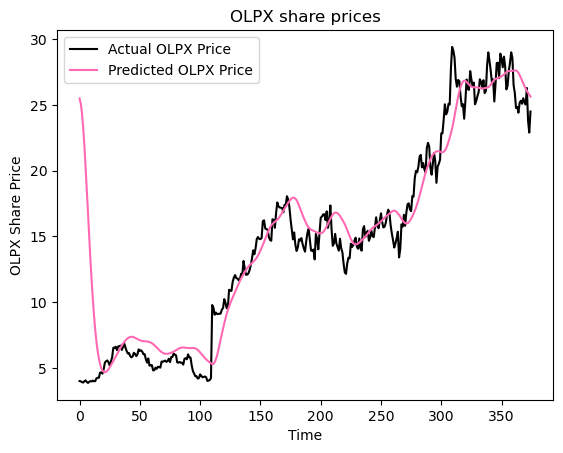

In [29]:
#Make Predicitions on test Data 
x_test = []
for x in range(prediction_days, len(model_inputs)):
    x_test.append(model_inputs[x-prediction_days:x, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

predicted_prices =model.predict(x_test)
predicted_prices = scaler.inverse_transform(predicted_prices)

#plt the test Predicition

plt.plot(actual_prices, color="black", label =f"Actual {company} Price")
plt.plot(predicted_prices, color ='hotpink', label =f"Predicted {company} Price")
plt.title(f"{company} share prices")
plt.xlabel('Time')
plt.ylabel(f"{company} Share Price")
plt.legend()
plt.show()

In [30]:
#predict the next day

real_data = [model_inputs[len(model_inputs)+ 1 - prediction_days:len(model_inputs+1),0]]
real_data = np.array(real_data)
real_data = np.reshape(real_data, (real_data.shape[0], real_data.shape[1],1))

prediction = model.predict(real_data)
prediction = scaler.inverse_transform(prediction)
print(f"Prediction:{prediction}")

1/1 [==============================] - 1s 837ms/step
Prediction:[[25.496313]]
